## Airbnb Price Prediction - Vienna with MLP
### Multi-Layer Perceptron Model for Price Prediction

The goal is to train this model to predict Airbnb listing prices.


In [55]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn for preprocessing and MLP
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Disable warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [56]:
import os

# Step 2: Load the data (Assumption: files are in the 'data' directory)
file_path = os.path.join('data', 'listings.csv')

try:
    listings = pd.read_csv(file_path)
    print(f"Successfully loaded: {listings.shape[0]} entries with {listings.shape[1]} features")
except FileNotFoundError:
    print("Error: listings.csv not found. Please download it from:")
    print("https://insideairbnb.com/get-the-data/")

# Preview of the dataset
listings.head(3)


Successfully loaded: 13790 entries with 79 features


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,38768,https://www.airbnb.com/rooms/38768,20250305023444,2025-03-08,city scrape,central cityapartement- wifi- nice neighbourhood,39m² apartment with beautiful courtyard of the...,the Karmeliterviertel became very popular in t...,https://a0.muscache.com/pictures/ad4089a3-5355...,166283,...,4.94,4.77,4.70,NaN,t,3,3,0,0,2.34
1,40625,https://www.airbnb.com/rooms/40625,20250305023444,2025-03-05,city scrape,"Near Palace Schönbrunn, Apt. 1",Welcome to my Apt. 1!<br /><br />This is a 2be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11509144/d55c...,175131,...,4.94,4.61,4.72,NaN,f,14,13,1,0,1.24
2,51287,https://www.airbnb.com/rooms/51287,20250305023444,2025-03-08,city scrape,little studio- next to citycenter- wifi- nice ...,small studio in new renovated old house and ve...,The neighbourhood has a lot of very nice littl...,https://a0.muscache.com/pictures/25163038/1c4e...,166283,...,4.95,4.87,4.59,NaN,t,3,3,0,0,2.22


In [57]:
# Step 3: Data cleaning and feature selection

# Prepare target variable (convert price to numerical float)
listings['price'] = listings['price'].str.replace(r'[\$,]', '', regex=True).astype(float)

# Select relevant features based on domain knowledge
features = [
    'neighbourhood_cleansed',  # Categorical (One-Hot)
    'room_type',               # Categorical
    'accommodates',            # Numerical
    'bathrooms',               # Numerical
    'bedrooms',                # Numerical
    'beds',                    # Numerical
    'review_scores_rating',    # Numerical
    'latitude',                # Numerical
    'longitude'                # Numerical
]

target = 'price'

# Clean dataset (handle NaN values)
data_clean = listings[features + [target]].dropna()

print(f"Remaining data points after cleaning: {len(data_clean)}")


Remaining data points after cleaning: 8168


In [58]:
# Step 4: Train-test split
X = data_clean[features]
y = data_clean[target]



# 1. Split data into training+validation (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# 2. Split training+validation into training (60%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 overall validation size
    random_state=42
)

print(f"Training data: {X_train.shape[0]} samples")
print(f"Validation data: {X_val.shape[0]} samples")
print(f"Test data: {X_test.shape[0]} samples")



Training data: 4900 samples
Validation data: 1634 samples
Test data: 1634 samples


In [59]:
# Definition der MLP-Klasse mit Pipeline und Preprocessing


class MLPModel:
    def __init__(self, numeric_features, categorical_features, hidden_layer_sizes=(100, 50), random_state=42):
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        
        # Preprocessor definieren
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), self.numeric_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), self.categorical_features)
            ])
        
        # Pipeline mit Preprocessor und MLPRegressor
        self.pipeline = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            ('regressor', MLPRegressor(
                hidden_layer_sizes=hidden_layer_sizes,
                activation='relu',
                solver='adam',
                max_iter=1,               # max_iter wird dynamisch beim Training gesetzt
                warm_start=True,          # damit man mehrfach trainieren kann
                random_state=random_state
            ))
        ])
    
    def partial_fit(self, X, y):
        # Ein einzelner Trainingsschritt
        self.pipeline.fit(X, y)
    
    def predict(self, X):
        return self.pipeline.predict(X)


In [60]:
# Cell 1: Training mit automatischer Validierung nach jeder Epoche

from sklearn.metrics import mean_absolute_error

def train_with_validation(model, X_train, y_train, X_val, y_val, epochs=20):
    train_mae_history = []
    val_mae_history = []
    
    for epoch in range(epochs):
        model.partial_fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_mae_history.append(train_mae)
        
        y_val_pred = model.predict(X_val)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_mae_history.append(val_mae)
        
        print(f"Epoch {epoch + 1}/{epochs} - Train MAE: {train_mae:.2f} - Val MAE: {val_mae:.2f}")
    
    return train_mae_history, val_mae_history


In [61]:
# Cell 2: Plot-Funktion für Trainings- und Validierungs-MAE-Verlauf

import matplotlib.pyplot as plt

def plot_training_validation(train_mae_history, val_mae_history):
    epochs = range(1, len(train_mae_history) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mae_history, label='Train MAE')
    plt.plot(epochs, val_mae_history, label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (€)')
    plt.title('Training and Validation MAE over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 1/20 - Train MAE: 104.19 - Val MAE: 111.80
Epoch 2/20 - Train MAE: 99.37 - Val MAE: 107.01
Epoch 3/20 - Train MAE: 91.36 - Val MAE: 99.01
Epoch 4/20 - Train MAE: 79.49 - Val MAE: 87.26
Epoch 5/20 - Train MAE: 64.26 - Val MAE: 72.25
Epoch 6/20 - Train MAE: 50.02 - Val MAE: 58.61
Epoch 7/20 - Train MAE: 45.09 - Val MAE: 55.63
Epoch 8/20 - Train MAE: 47.50 - Val MAE: 59.11
Epoch 9/20 - Train MAE: 46.72 - Val MAE: 58.17
Epoch 10/20 - Train MAE: 46.49 - Val MAE: 57.98
Epoch 11/20 - Train MAE: 46.13 - Val MAE: 57.62
Epoch 12/20 - Train MAE: 45.86 - Val MAE: 57.39
Epoch 13/20 - Train MAE: 45.62 - Val MAE: 57.18
Epoch 14/20 - Train MAE: 45.41 - Val MAE: 57.03
Epoch 15/20 - Train MAE: 45.22 - Val MAE: 56.91
Epoch 16/20 - Train MAE: 45.05 - Val MAE: 56.81
Epoch 17/20 - Train MAE: 44.92 - Val MAE: 56.73
Epoch 18/20 - Train MAE: 44.81 - Val MAE: 56.66
Epoch 19/20 - Train MAE: 44.71 - Val MAE: 56.60
Epoch 20/20 - Train MAE: 44.61 - Val MAE: 56.53


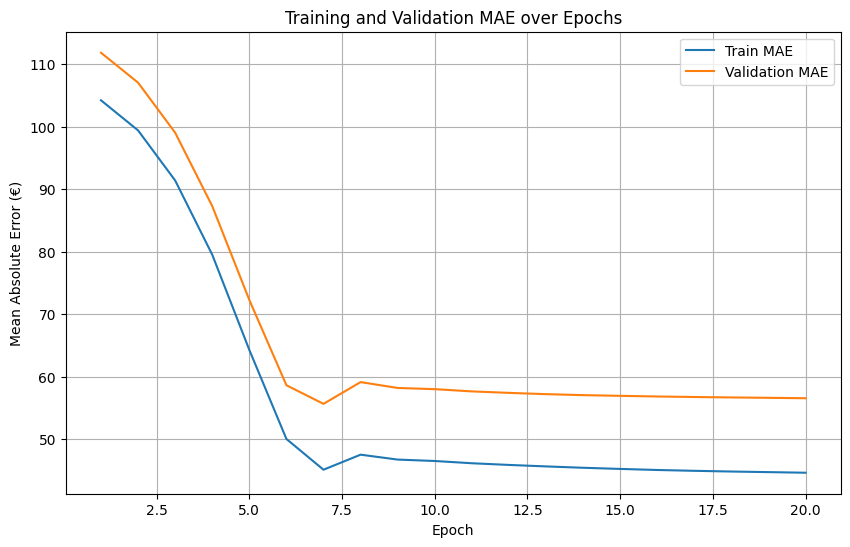

In [62]:
# Initialisierung der Modellinstanz mit den Features
model_instance = MLPModel(
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    hidden_layer_sizes=(100, 50),
    random_state=42
)

# Dann das Training mit deiner train_with_validation Funktion
train_mae_history, val_mae_history = train_with_validation(
    model=model_instance,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=20
)

# Plotten der Ergebnisse
plot_training_validation(train_mae_history, val_mae_history)
